In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ngngo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
data_dir = 'E:\Work_DatPT\Study\Master'
df_train = pd.read_csv('E:\Work_DatPT\Study\Master\SecBERT\multilabel-train\dataset_capec_multilabel_all.csv')
# df_train = pd.read_csv('E:\Work_DatPT\Study\Master\SecBERT\multilabel-train\dataset_capec_multilabel.csv')
df_train = df_train.head(300000)


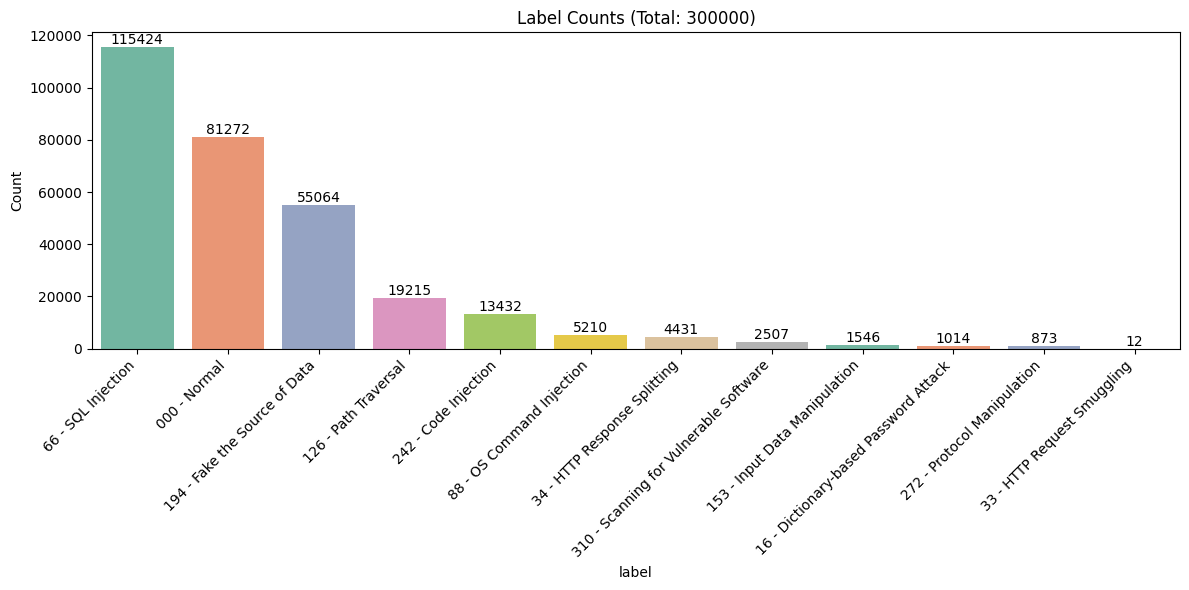

In [4]:
label_counts = df_train['label'].value_counts()

# Create a color palette for the bars
colors = sns.color_palette("Set2", len(label_counts))

# Create a bar chart with specified colors
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=label_counts.index, y=label_counts.values, palette=colors)

# Add labels to the bars
for i, (label, count) in enumerate(label_counts.items()):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Customize the chart
total_count = label_counts.sum()
plt.title(f'Label Counts (Total: {total_count})')
plt.ylabel('Count')

# Rotate the x-axis labels for readability
plt.xticks(rotation=45, ha="right")

# Show the chart
plt.tight_layout()
plt.show()


In [5]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import json


class Vectorizer:
    def __init__(self, method='BOW', ngram_range=(1, 1), max_features=300, emb_fname='', word_index_fname=''):
        self.method = method
        if self.method == 'BOW':
            self.vectorizer = CountVectorizer(analyzer='word', input='content', ngram_range=ngram_range, max_features=max_features)
        elif self.method == 'TFIDF':
            self.vectorizer = TfidfVectorizer(analyzer='word', input='content', max_features=max_features)
        elif self.method == 'Word2Vec':
            self.max_features = max_features
            self.emb_fname = emb_fname
            self.word_index_fname = word_index_fname
        else:
            raise ValueError('Feature extraction method does not exist.')

    def feature_extraction(self, X_train, X_test):
        train_data = self.vectorizer.fit_transform(X_train).toarray()
        test_data = self.vectorizer.transform(X_test).toarray()
        return train_data, test_data

    def get_word_index(self):
        word2id = json.load(open(self.word_index_fname, 'r'))
        return word2id

    def get_embedding_matrix(self):
        np.random.seed(0)
        word2id = self.get_word_index()
        embedding_matrix = np.random.uniform(-0.25, 0.25, [len(word2id) + 1, self.max_features])
        with open(self.emb_fname, 'r', encoding='utf-8') as f:
            for line in f:
                content = line.split(' ')
                if content[0] in word2id:
                    embedding_matrix[word2id[content[0]]] = np.array(list(map(float, content[1:])))
        return embedding_matrix

In [6]:
X_train, X_val, y_train, y_val = train_test_split(df_train["httprequest"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
# Optional (not effect very much)
df_train['httprequest'] = df_train['httprequest'].str.replace('/',' ')
df_train.head()

,httprequest,label
0,GET blog index.php 2020 04 04 voluptatum-repr...,000 - Normal
1,GET blog xmlrpc.php?rsd,000 - Normal
2,GET blog index.php 2020 04 04 nihil-tenetur-e...,000 - Normal
3,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal
4,GET blog index.php 2020 04 04 explicabo-qui-f...,000 - Normal


## Naive Bayes Classifier

In [7]:
from sklearn.naive_bayes import MultinomialNB
X_train, X_val, y_train, y_val = train_test_split(df_train["httprequest"],
                                                  df_train["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
vectorizer = Vectorizer('TFIDF')
train_features, test_features = vectorizer.feature_extraction(X_train, X_val)
mnb = MultinomialNB()
mnb.fit(train_features, y_train)
print(mnb.score(test_features, y_val))


0.8357666666666667


In [8]:
y_predict = mnb.predict(test_features)
print(classification_report(y_val,y_predict))

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                        precision    recall  f1-score   support

                          000 - Normal       0.84      0.75      0.79     16294
                  126 - Path Traversal       0.96      0.75      0.84      3830
         153 - Input Data Manipulation       0.16      0.77      0.26       314
 16 - Dictionary-based Password Attack       0.49      0.95      0.65       221
         194 - Fake the Source of Data       0.95      0.92      0.94     11072
                  242 - Code Injection       0.94      0.94      0.94      2747
           272 - Protocol Manipulation       0.00      0.00      0.00       154
310 - Scanning for Vulnerable Software       0.96      0.47      0.63       471
           33 - HTTP Request Smuggling       0.00      0.00      0.00         2
          34 - HTTP Response Splitting       0.97      0.97      0.97       846
                    66 - SQL Injection       0.83      0.88      0.85     23013
             88 - OS Command Injection 

e:\Python\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Classifier

In [9]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, criterion='gini')
rf.fit(train_features, y_train)
print(rf.score(test_features, y_val))

0.9273166666666667


In [10]:
y_predict = rf.predict(test_features)
print(classification_report(y_val,y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.88      0.98      0.93     16294
                  126 - Path Traversal       0.91      0.83      0.87      3830
         153 - Input Data Manipulation       0.30      0.09      0.14       314
 16 - Dictionary-based Password Attack       0.60      0.72      0.66       221
         194 - Fake the Source of Data       1.00      0.95      0.97     11072
                  242 - Code Injection       0.91      0.90      0.91      2747
           272 - Protocol Manipulation       0.76      0.46      0.57       154
310 - Scanning for Vulnerable Software       0.91      0.99      0.95       471
           33 - HTTP Request Smuggling       0.00      0.00      0.00         2
          34 - HTTP Response Splitting       0.97      0.98      0.97       846
                    66 - SQL Injection       0.96      0.94      0.95     23013
             88 - OS Command Injection 

## DecisionTreeClassifier

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini')
dt.fit(train_features, y_train)
print(dt.score(test_features, y_val))

0.9276


In [12]:
y_predict = dt.predict(test_features)
print(classification_report(y_val,y_predict))
# print('Confusion Matrix: \n',confusion_matrix(y_val, y_predict))

                                        precision    recall  f1-score   support

                          000 - Normal       0.88      0.98      0.93     16294
                  126 - Path Traversal       0.90      0.83      0.87      3830
         153 - Input Data Manipulation       0.31      0.13      0.18       314
 16 - Dictionary-based Password Attack       0.58      0.74      0.65       221
         194 - Fake the Source of Data       1.00      0.95      0.97     11072
                  242 - Code Injection       0.90      0.91      0.91      2747
           272 - Protocol Manipulation       0.75      0.51      0.60       154
310 - Scanning for Vulnerable Software       0.91      0.98      0.94       471
           33 - HTTP Request Smuggling       0.00      0.00      0.00         2
          34 - HTTP Response Splitting       0.96      0.98      0.97       846
                    66 - SQL Injection       0.96      0.94      0.95     23013
             88 - OS Command Injection 

In [13]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# from transformers import TrainingArguments, Trainer
# import numpy as np
# from datasets import Dataset

# df = pd.read_csv('E:\Work_DatPT\Study\Master\SecBERT\multilabel-train\dataset_capec_multilabel.csv')

# # Chuyển đổi nhãn thành số
# label_dict = {value: idx for idx, value in enumerate(df['label'].unique())}
# df['label'] = df['label'].map(label_dict)
# # Chia dữ liệu
# X_train, X_test, y_train, y_test = train_test_split(df['httprequest'], df['label'], test_size=0.2)

# # Tải tokenizer và mô hình
# model_name = "jackaduma/SecBERT"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_dict))

# # Tiền xử lý và mã hóa dữ liệu
# def tokenize_function(examples):
#     return tokenizer(examples, padding="max_length", truncation=True, max_length=512)

# train_encodings = tokenize_function(X_train.tolist())
# test_encodings = tokenize_function(X_test.tolist())

# # Giả sử `train_encodings` và `test_encodings` là kết quả của việc mã hóa dữ liệu văn bản của bạn
# train_dataset = Dataset.from_dict({
#     'input_ids': train_encodings['input_ids'],
#     'attention_mask': train_encodings['attention_mask'],
#     'labels': y_train
# })

# test_dataset = Dataset.from_dict({
#     'input_ids': test_encodings['input_ids'],
#     'attention_mask': test_encodings['attention_mask'],
#     'labels': y_test
# })

# # Thiết lập các tham số huấn luyện
# training_args = TrainingArguments(
#     output_dir="./results",                # thư mục để lưu kết quả và checkpoints
#     num_train_epochs=3,                    # tổng số epochs huấn luyện
#     per_device_train_batch_size=4,         # kích thước batch khi huấn luyện
#     per_device_eval_batch_size=4,          # kích thước batch khi đánh giá
#     warmup_steps=500,                      # số bước warmup
#     weight_decay=0.01,                     # weight decay để tránh overfitting
#     evaluation_strategy="epoch",           # đánh giá sau mỗi epoch
#     logging_dir='./logs',                  # thư mục để lưu logs
#     logging_steps=10,                      # log metric sau mỗi 10 bước
# )

# # Khởi tạo Trainer với mô hình và các tham số huấn luyện đã thiết lập
# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=train_dataset,
#     eval_dataset=test_dataset,
# )

# trainer.train()

# # Đánh giá mô hình
# predictions = trainer.predict(test_dataset)
# preds = np.argmax(predictions.predictions, axis=-1)

# # Tính toán và in ra f1 score, precision, và accuracy
# print(classification_report(y_test, preds, target_names=label_dict.keys()))


In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np
# Initialize tokenizer and model
model_name = "jackaduma/SecBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Sample data
data = {
    "httprequest": [
        "GET /tiki-listmovies.php?movie=../../../../../../etc/passwd%001234",
        "GET /tiki-listmovies.php?movie=../../../../../../etc/passwd%001234",
        "GET /tiki-listmovies.php?movie=../../../../../../etc/passwd%001234",
        "GET /tiki-listmovies.php?movie=../../../../../../etc/passwd%001234",
        "GET /zimbra/res/I18nMsg,AjxMsg,ZMsg,ZmMsg,AjxKeys,ZmKeys,ZdMsg,Ajx%20TemplateMsg.js.zgz?v=091214175450&skin=../../../../../../../../../dev/null%00",
        "GET /zimbra/res/I18nMsg,AjxMsg,ZMsg,ZmMsg,AjxKeys,ZmKeys,ZdMsg,Ajx%20TemplateMsg.js.zgz?v=091214175450&skin=../../../../../../../../../dev/null%00",
        "GET /zimbra/res/I18nMsg,AjxMsg,ZMsg,ZmMsg,AjxKeys,ZmKeys,ZdMsg,Ajx%20TemplateMsg.js.zgz?v=091214175450&skin=../../../../../../../../../dev/null%00",
        "GET /zimbra/res/I18nMsg,AjxMsg,ZMsg,ZmMsg,AjxKeys,ZmKeys,ZdMsg,Ajx%20TemplateMsg.js.zgz?v=091214175450&skin=../../../../../../../../../dev/null%00",
        "GET /zimbra/res/I18nMsg,AjxMsg,ZMsg,ZmMsg,AjxKeys,ZmKeys,ZdMsg,Ajx%20TemplateMsg.js.zgz?v=091214175450&skin=../../../../../../../../../etc/passwd%00",
        "GET /zimbra/res/I18nMsg,AjxMsg,ZMsg,ZmMsg,AjxKeys,ZmKeys,ZdMsg,Ajx%20TemplateMsg.js.zgz?v=091214175450&skin=../../../../../../../../../etc/passwd%00"
    ],
    "label": [
        "272 - Protocol Manipulation",
        "88 - OS Command Injection",
        "126 - Path Traversal",
        "310 - Scanning for Vulnerable Software",
        "272 - Protocol Manipulation",
        "88 - OS Command Injection",
        "126 - Path Traversal",
        "310 - Scanning for Vulnerable Software",
        "272 - Protocol Manipulation",
        "88 - OS Command Injection"
    ]
}

# Convert to DataFrame
# df = pd.read_csv('E:\Work_DatPT\Study\Master\SecBERT\multilabel-train\dataset_capec_multilabel_all.csv')
# df = pd.DataFrame(data)
df = pd.read_csv('E:\Work_DatPT\Study\Master\SecBERT\multilabel-train\dataset_capec_multilabel_all.csv').head(5000);
# Encode labels
label_encoder = LabelEncoder()
df['encoded_labels'] = label_encoder.fit_transform(df['label'])

# Tokenize http requests
tokens = tokenizer(df['httprequest'].tolist(), padding=True, truncation=True, return_tensors="pt")

# Predict
model.eval()  # Put model in evaluation mode
with torch.no_grad():
    outputs = model(**tokens)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Get the true labels and predicted labels
true_labels = df['encoded_labels'].tolist()
predicted_labels = predictions.numpy().tolist()
# Extract the labels parameter which should contain all unique label IDs
labels = df['encoded_labels'].unique()

# Make sure that the labels parameter is sorted since classification_report expects labels to be sorted
labels = np.sort(labels)
# Get classification report
report = classification_report(true_labels, predicted_labels, labels=labels, target_names=label_encoder.inverse_transform(labels))
print(report)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at jackaduma/SecBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


              precision    recall  f1-score   support

000 - Normal       1.00      0.88      0.94       500

   micro avg       1.00      0.88      0.94       500
   macro avg       1.00      0.88      0.94       500
weighted avg       1.00      0.88      0.94       500



In [ ]:
import pandas as pd
df = pd.read_csv('E:\Work_DatPT\Study\Master\SecBERT\multilabel-train\dataset_capec_multilabel_all.csv');
# Lọc ra các unique label
unique_labels = df['label'].unique()

# Tạo một dictionary để lưu trữ các dataframe mới cho mỗi label
label_dataframes = {}

# Lặp qua từng unique label và lấy 100 giá trị đầu tiên từ df cho mỗi label
for label in unique_labels:
    label_subset = df[df['label'] == label].head(100)
    label_dataframes[label] = label_subset[['httprequest', 'label']]

# In số lượng mẫu của mỗi label
for label, label_df in label_dataframes.items():
    print(f"Số lượng mẫu cho label '{label}': {label_df.shape[0]}")

# In ra 5 mẫu đầu tiên của mỗi label
for label, label_df in label_dataframes.items():
    print(f"\n5 mẫu đầu tiên cho label '{label}':")
    print(label_df.head())